# Visualizing and inspecting data

Before to use the data on a CNN model, we should examinate the data set in orden to identify possibles issues.

## Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab as py
import cv2
import h5py
from astropy.io import fits
import scipy.misc
from keras.preprocessing.image import array_to_img
import os
import random
from astropy.nddata import Cutout2D
import bisect

## Import Lensing Data Frame

In [2]:
lens_df = pd.read_csv('GroundBasedTraining/classifications.csv',delimiter=',', header=0)

Note that the Find_Lens_Challenge_1.0 data set (available at http://metcalf1.difa.unibo.it/blf-portal/gg_challenge.html) contains both true and false strong lens images. Since we aim to determinate physical parameters related to the strong lens phenomena we will only use the true lens images (a.k.a lens_tab['is_lens'] == 1). The data Find_Lens_Challenge_1.0 data set is split on two part Data.0 and Data.1. In each of aforementioned directories one finds the Public and Private folder. Public folders contain the data intended to train our model.

In [3]:
# True lens
lens_df = lens_df[lens_df['is_lens'] == 1]

folders = ['Data.0','Data.1']
valid_lens = []
valid_dict = {}
for fol in folders:
    # Lens on Data.X
    all_lens = os.listdir('GroundBasedTraining/'+fol+'/Public/Band4/')
    for lens in all_lens:
        # Extracting Lens ID
        vl = lens.replace('imageSDSS_','').replace('.fits','').split('-')[1]
        valid_lens.append(vl)
        valid_dict[vl] = fol
valid_lens = np.array(valid_lens)

# Cross check between True lens and Lens on Data.0
valid_tab = []
for lens in lens_df['ID']:
    pure_lens = np.repeat(lens,len(valid_lens))
    des = np.sum(valid_lens == str(lens))
    valid_tab.append(bool(des))
lens_df = lens_df[valid_tab]

lens_df = lens_df.reset_index(drop=True)

print('Data set is conformed by %i true lens images'%(len(lens_df)))
lens_df.head(5)

Data set is conformed by 8021 true lens images


,ID,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,100000,1,6.039480e-10,804,3714.6800
1,100002,1,7.180970e-11,51,57.6093
2,100003,1,1.764110e-11,347,18815.4000
3,100005,1,1.221390e-10,275,386.1880
4,100007,1,9.350820e-10,668,2188.0100


Now, we define a pythonic version of the matlab's function `imadjust` (see https://www.mathworks.com/help/images/ref/imadjust.html). This function is useful to display data and it won't be used on the training process. 

In [4]:
vout = (0,255)
def imadjust(src, tol=0.5, vin=[0,255], vout=vout):
    # src : input one-layer image (numpy array)
    # tol : tolerance, from 0 to 100.
    # vin  : src image bounds
    # vout : dst image bounds
    # return : output img
    dst = src.copy()
    tol = max(0, min(100, tol))
    if tol > 0:
        # Compute in and out limits
        # Histogram
        hist = np.zeros(256, dtype=np.int)
        for r in range(src.shape[0]):
            for c in range(src.shape[1]):
                hist[src[r,c]] += 1
        # Cumulative histogram
        cum = hist.copy()
        for i in range(1, len(hist)):
            cum[i] = cum[i - 1] + hist[i]
        # Compute bounds
        total = src.shape[0] * src.shape[1]
        low_bound = total * tol / 100
        upp_bound = total * (100 - tol) / 100
        vin[0] = bisect.bisect_left(cum, low_bound)
        vin[1] = bisect.bisect_left(cum, upp_bound)
    # Stretching
    if (vin[1] - vin[0]) > 0:
        scale = (vout[1] - vout[0]) / (vin[1] - vin[0])
    else:
        scale = 0   
    for r in range(dst.shape[0]):
        for c in range(dst.shape[1]):
            vs = max(src[r,c] - vin[0], 0)
            vd = min(int(vs * scale + 0.5) + vout[0], vout[1])
            dst[r,c] = vd
    return dst

## Displaying data

Each lens image is conform for four independent images of dimension (101x101) coming from four photometric bands : R, I, G and U. In this section, we display such images considering both the raw data and the denoised images. We also combine the channels R, I and G in order to reconstruct a RGI image. 

Set lens_kind = 0 to randomly choose a lens image, lens_kind = -1 to display a failed/bugged lens image or lens_kind = 1 to display a beatiful Einstein ring.

Filename: GroundBasedTraining/Data.0/Public/Band1/imageSDSS_R-108081.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (101, 101)   float32   
Filename: GroundBasedTraining/Data.0/Public/Band2/imageSDSS_I-108081.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (101, 101)   float32   
Filename: GroundBasedTraining/Data.0/Public/Band3/imageSDSS_G-108081.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (101, 101)   float32   
Filename: GroundBasedTraining/Data.0/Public/Band4/imageSDSS_U-108081.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (101, 101)   float32   


Text(0.5, 1.0, 'Result RGB')

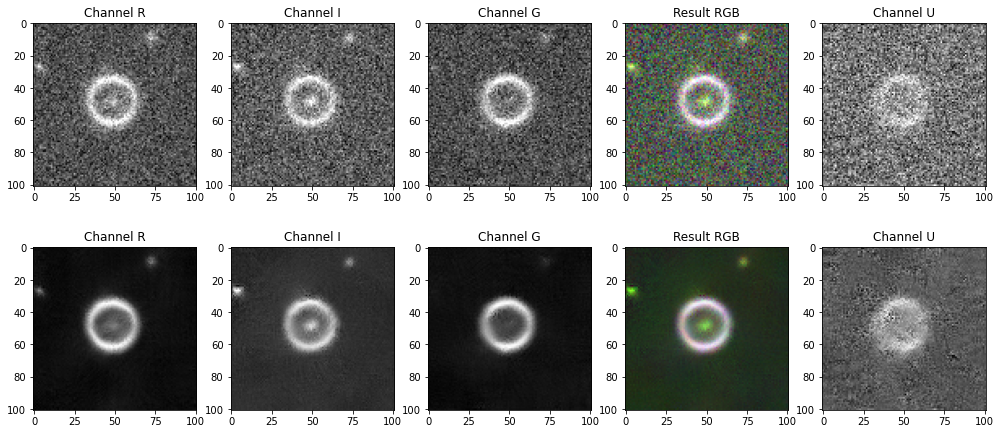

In [5]:
plt.rcParams["figure.figsize"] = (14,10)

lens_kind = 1
dirimg = 'GroundBasedTraining/Data.0/Public/Band3/'
idximg = 'imageSDSS_'

if lens_kind == 0:
    nmbimg = str(random.choice(lens_df['ID'])) # str(117926)
elif lens_kind == 1:
    nmbimg = str(108081)
else:
    nmbimg = str(112219)

col = 101
bands = ['R','I','G','U']
dictimg={}
imgi = np.zeros([101,101,3])
img = np.zeros([101,101,3])

fig, axs = plt.subplots(2,5)
fig.tight_layout(h_pad=-25, w_pad=0)

for ib, bnd in enumerate(bands):
    ib += 1
    root = 'GroundBasedTraining/Data.0/Public/Band%i/'%ib
    image_file = root+idximg+bnd+'-'+nmbimg+'.fits'
    fits.info(image_file)
    image_data = fits.getdata(image_file, ext=0)
    image_data= np.float32(image_data)
    image_data = cv2.normalize(image_data, None, 0, 255, cv2.NORM_MINMAX)
    image_data = np.uint8(image_data)
    image_datai = imadjust(image_data)
    dictimg[bnd+'i'] = image_datai    
    image_data = cv2.fastNlMeansDenoising(image_datai,None,30,7,21)
    dictimg[bnd] = image_data
    if ib != 4: #doesnt not include U band on RBG img
        imgi[:,:,ib-1] = image_datai
        img[:,:,ib-1] = image_data
        axs[0,ib-1].imshow(image_datai,cmap='gray')
        axs[0,ib-1].set_title('Channel '+bnd)
        axs[1,ib-1].imshow(image_data,cmap='gray')
        axs[1,ib-1].set_title('Channel '+bnd)
    else:
        axs[0,ib].imshow(image_datai,cmap='gray')
        axs[0,ib].set_title('Channel '+bnd)
        axs[1,ib].imshow(image_data,cmap='gray')
        axs[1,ib].set_title('Channel '+bnd)
        
rgbi = array_to_img(imgi)
rgbi = np.array(rgbi)
axs[0,3].imshow(rgbi,cmap='gray')
axs[0,3].set_title('Result RGB')

rgb = array_to_img(img)
rgb = np.array(rgb)
axs[1,3].imshow(rgb,cmap='gray')
axs[1,3].set_title('Result RGB')

Raw data is placed on the first row, while the denoised images are displayed on the second row.

Meanwhile display the images is an useful way to examinate the data, it would be unproductive pretend to find every bugged image on this way. So, in order to identify possible anomalies on the data set we compute the determinant of each image through the differents channel. For each lens, we compute the determinant of the R,G and I channel, if any of such determinants results lower that $10^{-3}$ such lens will be exclude from the data set.

In order to perform the above mentioned process we create the function `inspect_on_data`. This function computes the determinant of a set of images through the selected channel and returns a list with the bugged images' ID. You should provide the Lens Data Frame (data_frame), the name of the column containing the ID lens (x_name), the channels to be used (bands) and the dimension of the image to be considerate during the computation.

In [6]:
def inspect_on_data(data_frame,x_name,bands,dims):
    weirdos = []
    for len_to_inspect in data_frame[x_name]:
        fol = valid_dict[str(len_to_inspect)]
        for ib, bnd in enumerate(bands): # not include U
            ib += 1
            idximg = 'imageSDSS_'
            root = 'GroundBasedTraining/'+fol+'/Public/Band%i/'%ib
            len_file = root+idximg+bnd+'-'+str(len_to_inspect)+'.fits'
            len_data = fits.getdata(len_file, ext=0)
            len_data= np.float32(len_data)
            sC = len_data.shape[0] / 2
            len_data = Cutout2D(len_data, (sC, sC), (dims[0], dims[0]))
            len_data = np.array(len_data.data)
            len_data = cv2.normalize(len_data, None, 0, 255, cv2.NORM_MINMAX)
            len_data = np.float32(len_data)
            det_len = np.abs(np.linalg.det(len_data))
            if det_len < 1e-3:
                weirdos.append(len_to_inspect)
        
    weirdos = np.unique(np.array(weirdos))
    return weirdos

In [7]:
# Badboys (a.k.a bugged images)
new_dims = [101,101]
bands = ['R','I','G']
badboys = inspect_on_data(lens_df,'ID',bands,new_dims)

print('We have identify %i bugged images'%len(badboys))

We have identify 1123 bugged images


### Displaying bugged images

Randomly choosing a bugged image (from badboys list) to display.

Filename: GroundBasedTraining/Data.1/Public/Band1/imageSDSS_R-119909.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (101, 101)   float32   
Filename: GroundBasedTraining/Data.1/Public/Band2/imageSDSS_I-119909.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (101, 101)   float32   
Filename: GroundBasedTraining/Data.1/Public/Band3/imageSDSS_G-119909.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (101, 101)   float32   
Filename: GroundBasedTraining/Data.1/Public/Band4/imageSDSS_U-119909.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (101, 101)   float32   


Text(0.5, 1.0, 'Result RGB')

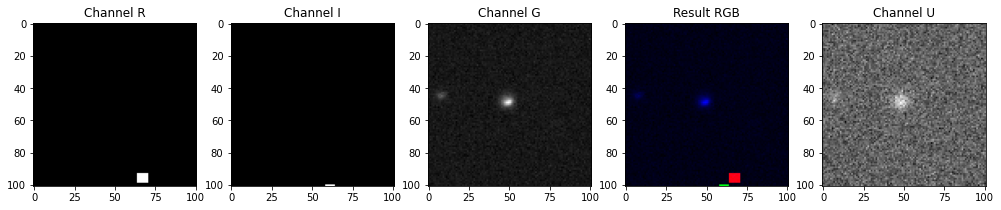

In [11]:
plt.rcParams["figure.figsize"] = (14,10)

nmbimg = str(np.random.choice(badboys))
fol = valid_dict[nmbimg]
bands = ['R','I','G','U']

dictimg={}
imgi = np.zeros([new_dims[0],new_dims[0],3])
img = np.zeros([new_dims[0],new_dims[0],3])

fig, axs = plt.subplots(1,5)
fig.tight_layout(h_pad=-25, w_pad=0)

for ib, bnd in enumerate(bands):
    ib += 1
    root = 'GroundBasedTraining/'+fol+'/Public/Band%i/'%ib
    image_file = root+idximg+bnd+'-'+nmbimg+'.fits'
    fits.info(image_file)
    image_data = fits.getdata(image_file, ext=0)
    image_data= np.float32(image_data)
    sC = image_data.shape[0] / 2
    image_data = Cutout2D(image_data, (sC, sC), (new_dims[0], new_dims[0]))
    image_data = np.array(image_data.data)
    image_data = cv2.normalize(image_data, None, 0, 255, cv2.NORM_MINMAX)
    image_data = np.float32(image_data)
    dictimg[bnd] = image_data
    if ib != 4: #doesnt not include U band on RBG img
        img[:,:,ib-1] = image_data
        axs[ib-1].imshow(image_data,cmap='gray')
        axs[ib-1].set_title('Channel '+bnd)
    else:
        axs[ib].imshow(image_data,cmap='gray')
        axs[ib].set_title('Channel '+bnd)
        
rgb = array_to_img(img)
rgb = np.array(rgb)
axs[3].imshow(rgb,cmap='gray')
axs[3].set_title('Result RGB')

We have to highlight that the discused method above could be not the most efficient way to explore the data, however we consider it is enough to reach the goals of this vainilla deep ensemble model.

## Exporting final data set

Now, we cross-check the lens data frame with the badboys list in order to exclude the bugged images. The final data set will be exported to be used in the training process. Note that we will also add the column `folder` on the final data frame. There, we include the in which folder (Data.0 or Data.1) is the lens image.

In [12]:
# Cross check between True lens and Lens bugged images
valid_tab = []
for lens in lens_df['ID']:
    pure_lens = np.repeat(lens,len(badboys))
    des = np.sum(badboys == lens)
    valid_tab.append(not bool(des))
lens_df = lens_df[valid_tab]

lens_df = lens_df.reset_index(drop=True)

# Adding column folder
lens_df['folder'] = np.zeros(len(lens_df['ID']))
for il, lens in enumerate(lens_df['ID']):
    lens_df['folder'][il] = valid_dict[str(lens)]


print('Final data set is conformed by %i true lens images'%(len(lens_df)))

<ipython-input-12-733eae7cf77e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lens_df['folder'][il] = valid_dict[str(lens)]


Final data set is conformed by 6898 true lens images


In [13]:
lens_df.to_csv('GroundBasedTraining/classifications_final.csv',index=False)